# Compare accuracies

In [1]:
import os
import fnmatch
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import isolate_int, flatten_2D_list
from data_extractor import output_vars_v4
import numpy as np
from copy import deepcopy

In [2]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_', 'TEST9_sel2_depth_']
labels = ['All features', '29 best features', '40 best features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_og_and_norm_weights_val')

In [3]:
vars_list = []

with open('saved_results/features_and_label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features_and_label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

with open('saved_results/features_and_label_sel2', 'rb') as file:
        vars_sel2 = pickle.load(file)
vars_list.append(vars_sel2)

In [4]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [5]:
def eval_accuracies(model_names, val, selected_vars):
    x_val = val[selected_vars]
    label_val = x_val.pop('signal_label').astype(float)
    weighted_accs = []
    for model_name in model_names:
        model = tf.keras.models.load_model(path+model_name)
        results = model.evaluate(x_val, label_val, sample_weight=val['weightNorm'])
        weighted_accs.append(results[-1])
    return weighted_accs


In [6]:
weighted_accs_list = []
for i, model_names in enumerate(model_names_list):
    weighted_accs = eval_accuracies(model_names, val, vars_list[i])
    weighted_accs_list.append(weighted_accs)

2023-05-29 18:04:57.289382: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 18:04:58.278613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-29 18:04:58.279388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


6295/6295 [==============================] - 23s 4ms/step - loss: 0.1585 - accuracy: 0.6649 - weighted_accuracy: 0.9468


In [7]:
sizes_list = []
for model_names in model_names_list:
    sizes = []
    for model_name in model_names:
        model = tf.keras.models.load_model(path+model_name)
        sizes.append(model.count_params())
    sizes_list.append(sizes)

In [8]:
with open('saved_results/TEST9_val_accuracy_by_width_and_depth', 'wb') as file:
    pickle.dump(weighted_accs_list, file)

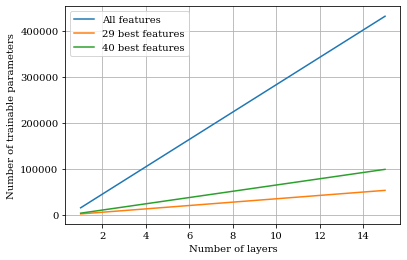

In [9]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], sizes_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Number of trainable parameters')
plt.legend()
plt.grid()

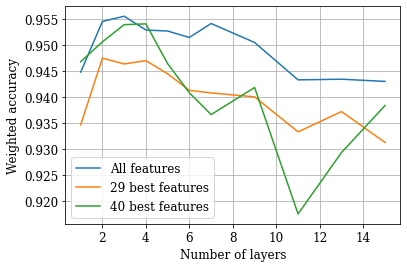

In [10]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], weighted_accs_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Weighted accuracy')
plt.legend()
plt.grid()
plt.savefig('Images/TEST9_global_v4_accuracy_vs_n_layers.pdf', bbox_inches='tight')

# Compare poisson significance estimator

In [1]:
from metrics import poisson_significance
import pandas as pd
from utils import plot_hist, isolate_int
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import fnmatch
import tensorflow as tf
from copy import deepcopy

In [39]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_', 'TEST9_sel2_depth_']
labels = ['All features', '29 best features', '40 best features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_og_and_norm_weights_val')
vars_list = []

with open('saved_results/features_and_label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features_and_label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

with open('saved_results/features_and_label_sel2', 'rb') as file:
        vars_sel2 = pickle.load(file)
vars_list.append(vars_sel2)

In [3]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [4]:
print(len(val[val['channel'] == 0]))

7961


2023-05-29 22:14:20.483545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 22:14:21.470550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-29 22:14:21.471319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5
100%|██████████| 100/100 [00:00<00:00, 1269.55it/s]


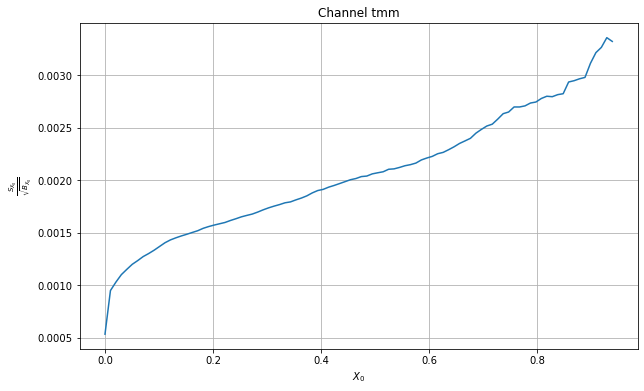

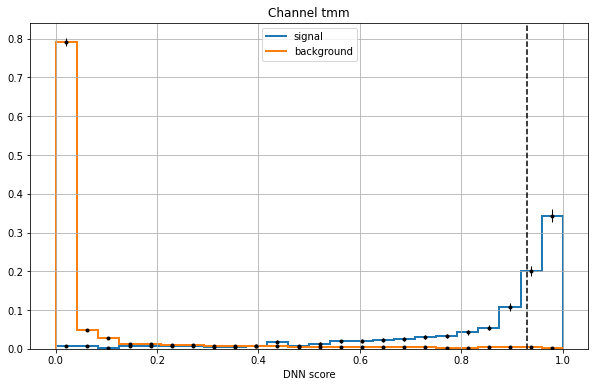

In [5]:
#Lists of results and plot with the same structure as the model_names_list:
#First index for the width of the DNN (either all features, or the selection)
#second index for the depth of the DNN
#third index for the channel
x0s_list = []
significances = []
sigs_plots = []
hists_plots = []

with open('extracted_data/TEST9_global_v4_all_normalized_channel_indices', 'rb') as file:
    channel_indices = pickle.load(file)

for i, model_names in enumerate(model_names_list):
    #Create the lists for the results for 1 width (and all depths)
    x0s_depth = []
    sigs_depth = []
    # sigs_plots_depth = []
    # hists_plots_depth = []

    for j, model_name in enumerate(model_names):
        model = tf.keras.models.load_model(path+model_name)

        #Create the lists for the results for 1 depths (and all channels)
        x0s_channel = []
        sigs_channel = []
        # sigs_plots_channel = []
        # hists_plots_channel = []

        for channel in channel_indices:
            val_channel = val[val['channel'] == channel_indices[channel]]
            x_val_channel = val_channel[vars_list[i]]
            label_val_channel = x_val_channel.pop('signal_label')
            scores = model.predict(x_val_channel)
            scores = np.squeeze(scores)

            sigs, bins = poisson_significance(scores, label_val_channel, val_channel['weightOriginal'], 100)
            
            sigs_channel.append(sigs)
            x0s_channel.append(bins)
            
            if not len(bins) == 0:
                threshold = bins[np.argmax(sigs)]
            else:
                threshold = np.NAN

            if i==0 and j==1 and channel=='tmm':
                #Plot of the significance as a function of the cut
                fig_s, ax_s = plt.subplots(1, 1, figsize=(10, 6))
                ax_s.plot(bins,sigs)
                ax_s.set_xlabel('$X_0$')
                ax_s.set_ylabel(r'$\frac{S_{X_0}}{\sqrt{B_{X_0}}}$')
                ax_s.set_title('Channel '+channel)
                ax_s.grid()
                sigs_plots.append(fig_s)

                #Plot of the histograms with optimal cut
                val_mod = deepcopy(val_channel)
                val_mod['scores'] = scores
                hist_bins = np.linspace(0,1,25)
                fig = plot_hist(val_mod, 'scores', 'DNN score', hist_bins, mode='simple_signal_label', weights_name='weightOriginal')[0]
                ax = fig.gca()
                if threshold == threshold:
                    ax.axvline(threshold, color='k', linestyle='--', label='$Optimal cut$')
                ax.set_title('Channel '+channel)
                hists_plots.append(fig)

        x0s_depth.append(x0s_channel)
        sigs_depth.append(sigs_channel)
        # sigs_plots_depth.append(sigs_plots_channel)
        # hists_plots_depth.append(hists_plots_channel)
    
    x0s_list.append(x0s_depth)
    significances.append(sigs_depth)
    # sigs_plots.append(sigs_plots_depth)
    # hists_plots.append(hists_plots_depth)

Try to plot [0][1][2] (all variables, 2nd depth, channel tmm)

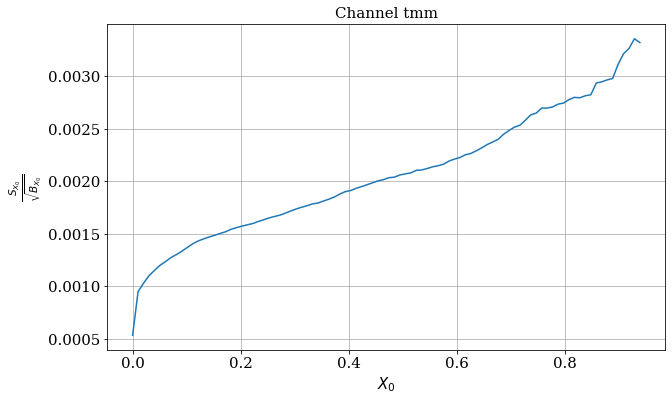

In [6]:
from IPython.display import display
import matplotlib as mpl
fig = sigs_plots[0]
ax = fig.gca()
ax.axis('on')
fig.patch.set_facecolor('white')
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig)

In [18]:
mpl.rcParams['text.usetex'] = False

In [30]:
print(labels)
labels_new = labels

[]


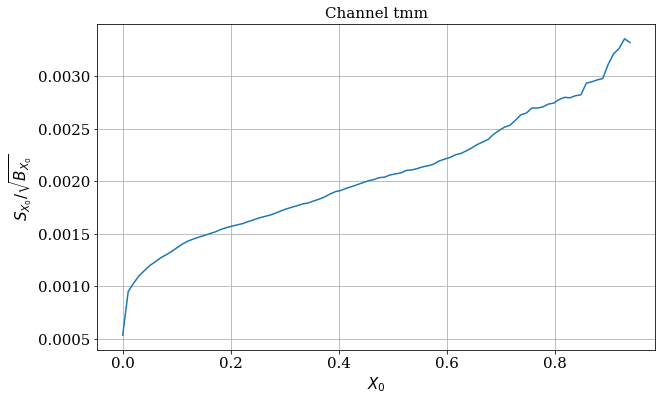

In [34]:
fig_s = sigs_plots[0]
ax = fig_s.gca()
ax.axis('on')
ax.set_ylabel(r'$S_{X_0}/\sqrt{B_{X_0}}$')
fig.patch.set_facecolor('white')
for text in fig_s.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig_s)

In [35]:
fig_s.savefig('Images/TEST9_global_v4_depth_3_channel_tmm_sig_X_0.pdf', bbox_inches = 'tight')

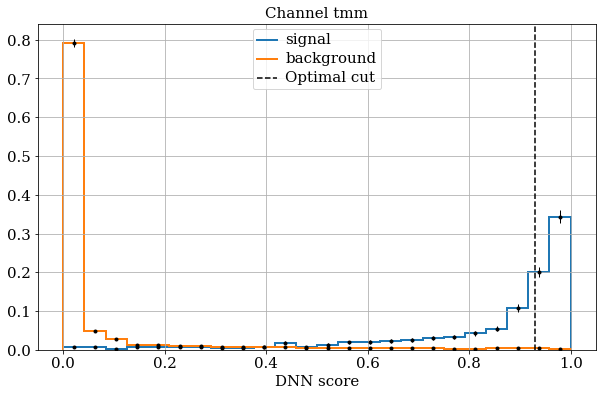

In [25]:
fig = hists_plots[0]
ax = fig.gca()
ax.axis('on')
fig.patch.set_facecolor('white')
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig)

In [27]:
fig.savefig('Images/TEST9_global_v4_depth_3_channel_tmm_DNN_score_hist.pdf', bbox_inches = 'tight')

In [20]:
with open('saved_results/TEST9_val_significance_by_width_depth_and_channel', 'wb') as file:
    pickle.dump(significances, file)

In [36]:
max_sigs_list = []
for sigs_width in significances:
    max_sigs_width = []
    for sigs_depth in sigs_width:
        sig_cmb = 0
        for sigs_channel in sigs_depth:
            if len(sigs_channel) != 0:
                sig_cmb += max(sigs_channel)**2
        sig_cmb = np.sqrt(sig_cmb)
        max_sigs_width.append(sig_cmb)
    max_sigs_list.append(max_sigs_width)

In [37]:
print(max_sigs_list)
print(depths_list)

[[0.006787106315035157, 0.007270676805542457, 0.006693459174868034, 0.006909988888595055, 0.006796871383285461, 0.006505388653461822, 0.006948955781161505, 0.006928538889348479, 0.006980866523285018, 0.006490505488290983, 0.006892694998976811], [0.00691049960166422, 0.006209803370046479, 0.0067386015565009125, 0.006599606529220197, 0.0065871692682382375, 0.006725665911026645, 0.006833979629753739, 0.0066754036510600434, 0.0068069629804727435, 0.006474292933931562, 0.006873293448381044], [0.006322880284438095, 0.006947026955462152, 0.0068146472006246454, 0.007198040813673074, 0.007103738997990046, 0.006843417785245628, 0.006493057107708647, 0.006607722594970588, 0.006677642920780036, 0.007123180645944648, 0.006788447423991183]]
[[6, 3, 13, 7, 5, 11, 4, 2, 15, 1, 9], [5, 1, 13, 15, 6, 11, 4, 7, 2, 9, 3], [13, 4, 15, 3, 5, 7, 11, 6, 9, 2, 1]]


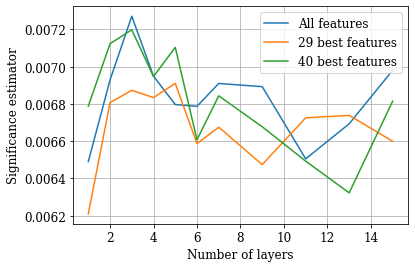

In [40]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], max_sigs_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Significance estimator')
plt.legend()
plt.grid()
plt.savefig('Images/TEST9_global_v4_sig_vs_n_layers.pdf', bbox_inches = 'tight')

# Simple score histograms

In [1]:
import pandas as pd
import os
import fnmatch
import numpy as np
from utils import isolate_int, normalize, plot_hist
import pickle
import tensorflow as tf
from copy import deepcopy
import matplotlib as mpl

In [2]:
model = tf.keras.models.load_model('saved_models/TEST9_sel2_depth_4')

2023-05-31 00:49:44.179995: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 00:49:45.171543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-31 00:49:45.172287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [3]:
with open('extracted_data/TEST9_global_v4_all_normalized_channel_indices', 'rb') as file:
    channel_indices = pickle.load(file)

In [4]:
channels = os.listdir('/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/')
mass_hyps = []
file_list = fnmatch.filter(os.listdir(f'/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/{list(channel_indices.keys())[0]}/anatuple'), '*.root')
for filename in file_list:
    if filename[:len('HNL')] == 'HNL':
            mass_hyps.append(isolate_int(filename, separators=['-', '_'])[0])
mass_hyps = np.unique(np.array(mass_hyps))
print(channels)
print(mass_hyps)

['tte', 'tee', 'tmm', 'tem', 'ttm']
[  85  100  125  150  200  250  300  350  400  450  500  600  700  800
  900 1000]


In [5]:
with open('saved_results/features_and_label_sel2', 'rb') as file:
    features = pickle.load(file)

In [6]:
test = pd.read_pickle('extracted_data/TEST9_global_v4_og_and_norm_weights_test')

In [123]:
channel = channels[4]
mass_hyp = mass_hyps[-1]

test_loc = deepcopy(test.loc[(test['channel']==channel_indices[channel]) & 
                    ((test['mass_hyp'] == mass_hyp) | (test['signal_label']==0))])

test_loc = normalize(test_loc, 'signal_label', len(test_loc['event']), 'weightOriginal')


x_test = test_loc[features]
label_test = x_test.pop('signal_label')

In [124]:
results = model.evaluate(x_test, label_test, sample_weight=test_loc['weightOriginal'])
scores = model.predict(x_test)
test_loc['scores'] = scores

1600/1600 [==============================] - 6s 4ms/step - loss: 1.7370 - accuracy: 0.4071 - weighted_accuracy: 0.6930


In [125]:
print(len(scores))

51194


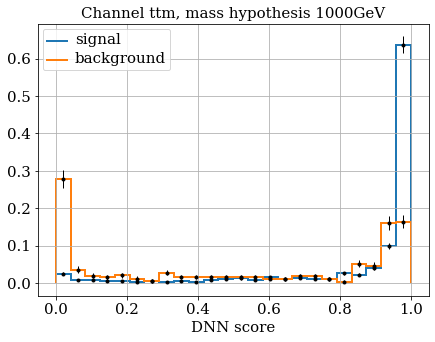

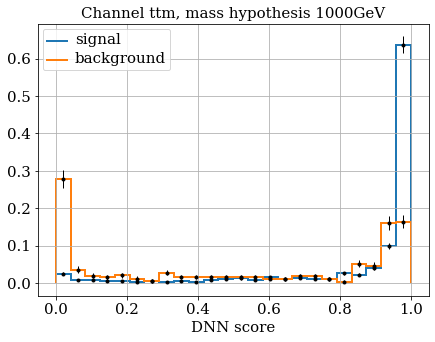

In [126]:
bins = np.linspace(0,1,25)
fig = plot_hist(test_loc, 'scores', 'DNN score', bins, mode='simple_signal_label', weights_name='weightNorm', figsize=(7,5))[0]
ax = fig.gca()
# ax.legend(loc='upper left')
ax.axis('on')
ax.set_title('Channel {}, mass hypothesis {}GeV'.format(channel, mass_hyp))
fig.patch.set_facecolor('white')
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig)

In [127]:
fig.savefig('Images/TEST9_sel2_score_hist_{}_{}.pdf'.format(mass_hyp, channel), bbox_inches = 'tight')

In [128]:
print(channel)
print(results)

ttm
[1.7370233535766602, 0.4070985019207001, 0.6930044293403625]
